## 1. Import Modules ⚙️

In [20]:
# 1) import modules

import numpy as np
import pandas as pd # import library for data analysis
import openpyxl # for reading excel files

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for nicer plots
sns.set_theme('talk', style = 'white')

## 2. Data Processing

In this section, we need to load the data and clean it.

In [21]:
# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

In [22]:
# Clean data 

# Subset relevant columns and compute per capita real GDP
data = data.loc[:, ("country", "year", "rgdpna", "pop", "emp", "rnna")]
data["rgdpna_pc"] = data["rgdpna"] / data["pop"]

# Select Indonesia as country
data = data.loc[data["country"] == "Indonesia", ("year", "rgdpna_pc", "rgdpna", "emp", "rnna")]
data = data.reset_index(drop = True)

# Subset the RGDP per capita series
ymax = 2019
ymin = 1960
Y = data.loc[np.logical_and(data["year"] <= ymax, data["year"] >= ymin), "rgdpna_pc"]
y = np.log(Y)
data = data[data["year"] >= ymin] 

# Compute separate sample sizes for the subsample used for regression and the whole sample
T = len(Y) # sample size used for regression
T_all = data["year"].max() - (ymin - 1) # number of all years in the data 

## 3. Computing Different Trend Specifications

We want to compute four different specifications: 

(i) additive + linear 

(ii) additive + quadratic

(iii) exponential + linear 

(iv) exponential + quadratic.

### 3.1.1 Additive + Linear Time Trend

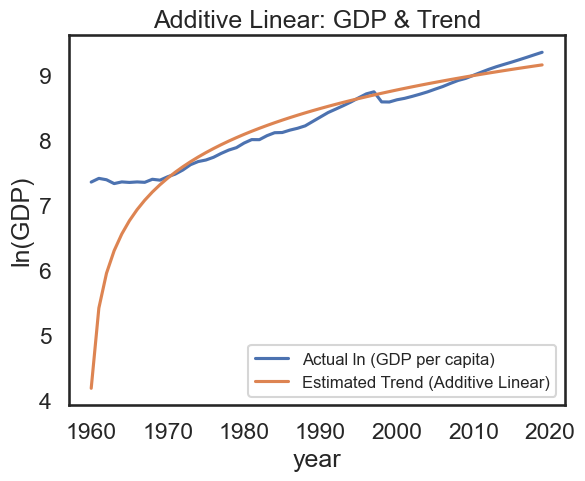

In [23]:
# Additive Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T) # initialise an empty vector for the first regressor (representing the intercept)
x2 = np.empty(T) # initialise an empty vector for the second regressor (representing the time variable)

for t in range(T):
    x1[t] = 1. # Set all elements of x1 to 1 (constant term for regression)
    x2[t] = t + 1 # Time trend: t starts at 0, so we shift it to start at 1

a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)

# Having computed the coefficients, we can now evaluate the trend for the entire time series, i.e also for years later than those used in the regression.

# Initialise predicted values yhat
Yhat_add_lin = np.empty(T_all) # creates an array of size T_all

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # t+1 ensures the time index starts at 1 instead of 0 (because Python starts counting from 0).

# Let us convert into log-units
yhat_add_lin = np.log(Yhat_add_lin)

lw = 4  # Make plotted line thicker

# Create figure
plt.figure()

# Plot actual GDP per capita
plt.plot(data['year'], np.log(data['rgdpna_pc']), label="Actual ln (GDP per capita)")

# Plot estimated trend
plt.plot(data['year'], yhat_add_lin, label="Estimated Trend (Additive Linear)")

# Labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

# Title
plt.title("Additive Linear: GDP & Trend")

# Add legend with size adjustments
plt.legend(fontsize=12, framealpha=0.8, loc="best")  # Adjust font size & transparency

# Show plot
plt.show()


### 3.1.2 Additive + Quadratic Time Trend

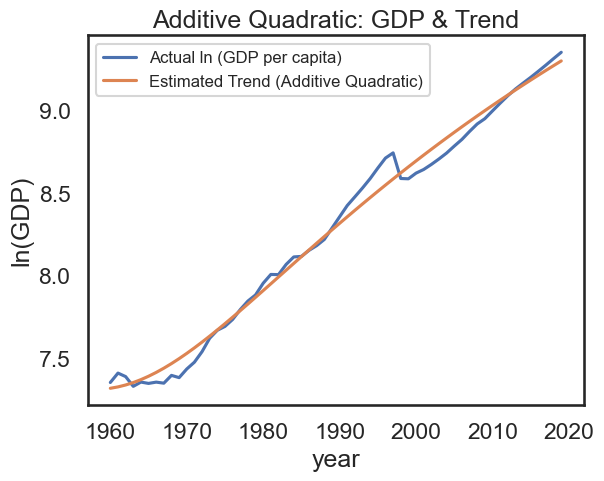

In [24]:
# Additive Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T,
# Third regressor x3 is the quadratic term x2^2
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T)  # Initialise an empty vector for the first regressor (representing the intercept)
x2 = np.empty(T)  # Initialise an empty vector for the second regressor (representing the time variable)
x3 = np.empty(T)  # Initialise an empty vector for the third regressor (representing the quadratic term)

for t in range(T):
    x1[t] = 1.  # Set all elements of x1 to 1 (constant term for regression)
    x2[t] = t + 1  # Time trend: t starts at 0, so we shift it to start at 1
    x3[t] = (t + 1) ** 2  # Quadratic time trend: squared time variable

# Compute regression coefficients using the provided function
a_add_quad, b_add_quad, c_add_quad = get_regression_coefs(Y, x1, x2, x3)

# Initialise predicted values yhat
Yhat_add_quad = np.empty(T_all)  # Creates an array of size T_all

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b_add_quad * (t + 1) + c_add_quad * ((t + 1) ** 2)  
    # t+1 ensures the time index starts at 1 instead of 0 (because Python starts counting from 0).

# Let us convert into log-units
yhat_add_quad = np.log(Yhat_add_quad)  

lw = 4  # Make plotted line thicker

# Create figure
plt.figure()

# Plot actual GDP per capita
plt.plot(data['year'], np.log(data['rgdpna_pc']), label="Actual ln (GDP per capita)")

# Plot estimated quadratic trend
plt.plot(data['year'], yhat_add_quad, label="Estimated Trend (Additive Quadratic)")

# Labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

# Title
plt.title("Additive Quadratic: GDP & Trend")

# Add legend with size adjustments
plt.legend(fontsize=12, framealpha=0.8, loc="best")  # Adjust font size & transparency

# Show plot
plt.show()


### 3.1.3 Exponential + Linear Time Trend

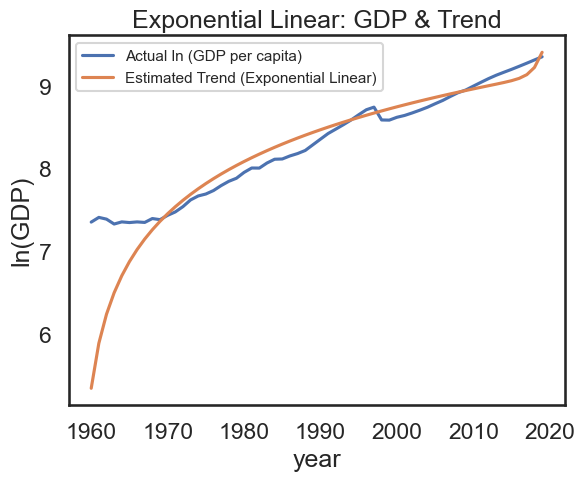

In [25]:
# Exponential + Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# Third regressor x3 is the exponential term e^(t)

x1 = np.empty(T)  # Intercept
x2 = np.empty(T)  # Linear time trend
x3 = np.empty(T)  # Exponential term

for t in range(T):
    x1[t] = 1.  # Constant term
    x2[t] = t + 1  # Time trend: Shift index to start from 1
    x3[t] = np.exp(t + 1)  # Exponential growth term e^(t+1)

# Compute regression coefficients using the provided function
a_exp_lin, b_exp_lin, c_exp_lin = get_regression_coefs(Y, x1, x2, x3)

# Initialise predicted values yhat
Yhat_exp_lin = np.empty(T_all)  # Creates an array of size T_all

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1) + c_exp_lin * np.exp(t + 1)  
    # Only includes linear and exponential terms (NO quadratic term)

# Convert into log-units
yhat_exp_lin = np.log(Yhat_exp_lin)  

lw = 4  # Make plotted line thicker

# Create figure
plt.figure()

# Plot actual GDP per capita in log-units
plt.plot(data['year'], np.log(data['rgdpna_pc']), label="Actual ln (GDP per capita)")

# Plot estimated linear + exponential trend
plt.plot(data['year'], yhat_exp_lin, label="Estimated Trend (Exponential Linear)")

# Labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

# Title
plt.title("Exponential Linear: GDP & Trend")

# Add legend with size adjustments
plt.legend(fontsize=11, framealpha=0.8, loc="best")  # Adjust font size & transparency

# Show plot
plt.show()


### 3.1.4 Exponential + Quadratic Time Trend

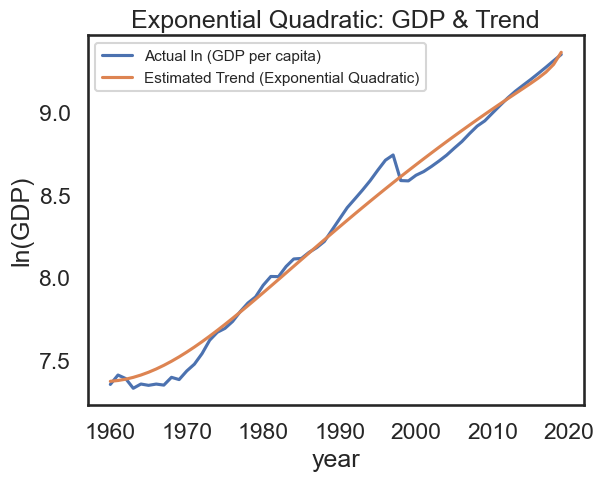

In [26]:
# Quadratic + Exponential Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the quadratic term T^2,
# Third regressor x3 is the exponential term e^(t)

x1 = np.empty(T)  # Intercept
x2 = np.empty(T)  # Quadratic term
x3 = np.empty(T)  # Exponential term

for t in range(T):
    x1[t] = 1.  # Constant term for regression
    x2[t] = (t + 1) ** 2  # Quadratic trend (squared time variable)
    x3[t] = np.exp(t + 1)  # Exponential growth term e^(t+1)

# Compute regression coefficients using the provided function
a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(Y, x1, x2, x3)

# Initialise predicted values yhat
Yhat_exp_quad = np.empty(T_all)  # Creates an array of size T_all

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_exp_quad[t] = a_exp_quad + b_exp_quad * ((t + 1) ** 2) + c_exp_quad * np.exp(t + 1)  
    # Strictly follows quadratic + exponential trend

# Convert into log-units
yhat_exp_quad = np.log(Yhat_exp_quad)  

lw = 4  # Make plotted line thicker

# Create figure
plt.figure()

# Plot actual GDP per capita in log-units
plt.plot(data['year'], np.log(data['rgdpna_pc']), label="Actual ln (GDP per capita)")

# Plot estimated quadratic + exponential trend
plt.plot(data['year'], yhat_exp_quad, label="Estimated Trend (Exponential Quadratic)")

# Labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

# Title
plt.title("Exponential Quadratic: GDP & Trend")

# Add legend with size adjustments
plt.legend(fontsize=11, framealpha=0.8, loc="best")  # Adjust font size & transparency

# Show plot
plt.show()


### 3.1.5 Combining the different trends

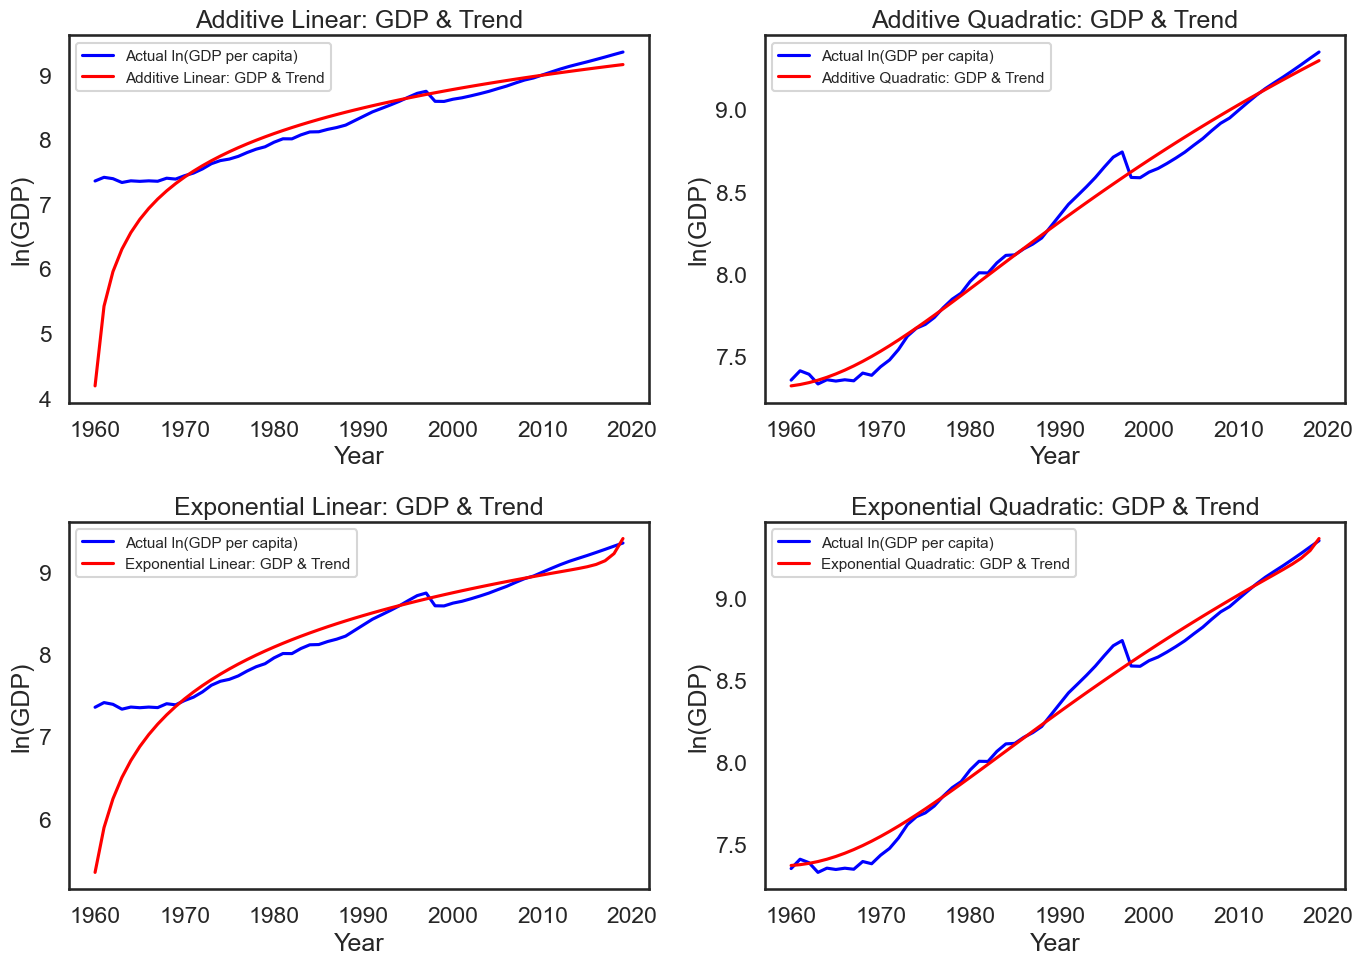

In [27]:
# Create a figure with a 2x2 subplot layout for comparing all models
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns for four models

# Titles for each subplot
titles = [
    "Additive Linear: GDP & Trend",
    "Additive Quadratic: GDP & Trend",
    "Exponential Linear: GDP & Trend",
    "Exponential Quadratic: GDP & Trend"
]

# Correct corresponding predicted values for each trend model
predicted_trends = [yhat_add_lin, yhat_add_quad, yhat_exp_lin, yhat_exp_quad] 

# Loop through each subplot and plot the actual & estimated trends
for i, ax in enumerate(axs.flat):
    ax.plot(data["year"], np.log(data["rgdpna_pc"]), label="Actual ln(GDP per capita)", color="blue")
    
    # Ensure correct predictions are plotted
    ax.plot(range(ymin, ymin + T_all), predicted_trends[i], label=titles[i], color="red")

    # Labels & title
    ax.set_xlabel("Year")
    ax.set_ylabel("ln(GDP)")
    ax.set_title(titles[i])
    ax.legend(fontsize=11, framealpha=0.8, loc="best")  # Adjust legend size & transparency

# Adjust layout for better spacing
plt.tight_layout()

# Show the comparison plot
plt.show()


## 4. Extract TFP measure

,year,tfp
10,1960,2560.91
11,1961,2806.35
12,1962,2753.40
13,1963,2569.47
14,1964,2701.62


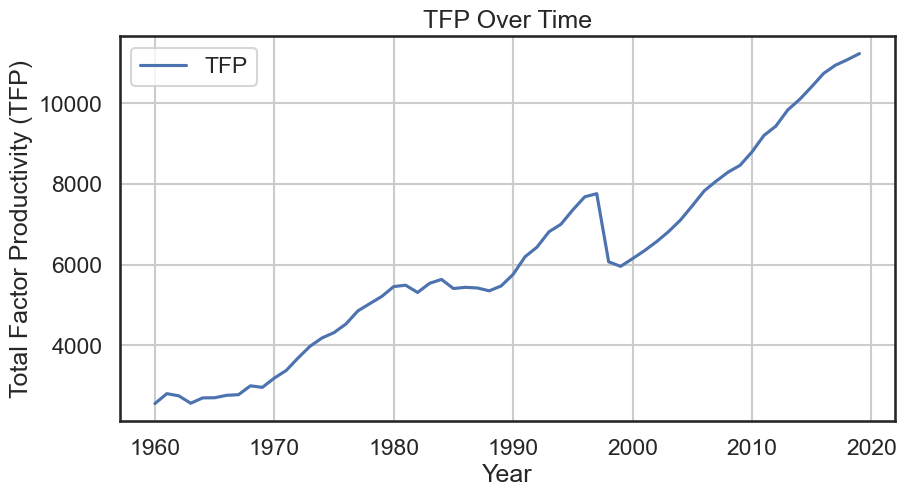

In [28]:
# Set display settings for float precision
pd.set_option("display.float_format", "{:.2f}".format)

# Set parameter for capital share in output
alpha = 0.3  # Given benchmark

# Extract data as NumPy arrays for performance efficiency
year = data["year"].to_numpy()
Y = data["rgdpna"].to_numpy()  # Real GDP
K = data["rnna"].to_numpy()  # Capital stock
L = data["emp"].to_numpy()  # Number of employed workers

# Compute TFP using the adjusted Solow residual formula
tmp = Y / (K**alpha * L**(1 - alpha))
A = tmp ** (1 / (1 - alpha))  # Adjusted TFP formula

# Store TFP in the dataset
data["tfp"] = A

# Display the first few rows to check results
display(data[["year", "tfp"]].head())

# Plot TFP over time
plt.figure(figsize=(10, 5))
plt.plot(data["year"], data["tfp"], linestyle="-", color="b", label="TFP")  # No markers
plt.xlabel("Year")
plt.ylabel("Total Factor Productivity (TFP)")
plt.title("TFP Over Time")
plt.legend()
plt.grid()
plt.show()


## 5. Growth Accounting

In [29]:
# Subset relevant columns and compute per capita real GDP
data = data.loc[:, ("year", "rgdpna", "emp", "rnna")]

# Set parameter for capital share
alpha = 0.3

# Extract data as NumPy arrays
year = data["year"].to_numpy()
Y = data["rgdpna"].to_numpy()  # Real GDP
K = data["rnna"].to_numpy()  # Capital stock
L = data["emp"].to_numpy()  # Labour (employment)

# Compute TFP using the Solow residual
A = Y / (K**alpha * L**(1 - alpha))

# Function to compute growth rates using log differences
def compute_growth_rate(X):
    return np.log(X[1:] / X[:-1])

# Compute growth rates
dY = compute_growth_rate(Y)  # GDP growth
dA = compute_growth_rate(A)  # TFP growth
dK = compute_growth_rate(K)  # Capital growth
dL = compute_growth_rate(L)  # Labour growth

# === FIX: Handle division by zero in growth contributions === #
# Replace zero GDP growth rates with NaN to prevent division by zero
dY[dY == 0] = np.nan  

# Compute contributions safely (avoiding division by zero)
contrib_dK = np.where(np.isnan(dY), np.nan, alpha * dK / dY)
contrib_dL = np.where(np.isnan(dY), np.nan, (1 - alpha) * dL / dY)
contrib_dA = np.where(np.isnan(dY), np.nan, dA / dY)

# === GROWTH RATE DISPLAY === #
df_growth = pd.DataFrame({
    "Year": [f"{y1}-{y2}" for y1, y2 in zip(year[:-1], year[1:])],
    "ln(Y_t/Y_{t-1})": dY
})

# Set display options for clean formatting
pd.set_option("display.float_format", "{:.4f}".format)

# Display Year-by-Year Growth Rate Table
print("\n== Year by Year Growth Rate ==\n")
display(df_growth)

# === CONTRIBUTION DISPLAY === #
df_contribs = pd.DataFrame({
    "Year": [f"{y1}-{y2}" for y1, y2 in zip(year[:-1], year[1:])],
    "K Contribution": contrib_dK,
    "L Contribution": contrib_dL,
    "A Contribution": contrib_dA
})

# Set "Year" as the index
df_contribs = df_contribs.set_index("Year")

# Display Year-by-Year Contributions Table
print("\n== Year by Year Contributions ==\n")
display(df_contribs)

# === COMPUTE & DISPLAY AVERAGE CONTRIBUTIONS === #
avg_contribs = df_contribs.mean()
print("\n== Average Contributions Over Time ==\n")
display(avg_contribs)



== Year by Year Growth Rate ==



,Year,ln(Y_t/Y_{t-1})
0,1960-1961,0.0789
1,1961-1962,-0.0015
2,1962-1963,-0.0394
3,1963-1964,0.0454
4,1964-1965,0.0117
5,1965-1966,0.0275
6,1966-1967,0.0135
7,1967-1968,0.0669
8,1968-1969,0.0062
9,1969-1970,0.0720



== Year by Year Contributions ==



,K Contribution,L Contribution,A Contribution
Year,,,
1960-1961,0.0147,0.1732,0.8122
1961-1962,0.2222,-7.9936,8.7714
1962-1963,0.0814,-0.3092,1.2277
1963-1964,-0.0413,0.2689,0.7724
1964-1965,-0.1368,1.0473,0.0895
1965-1966,-0.0069,0.4459,0.5610
1966-1967,-0.1933,0.9118,0.2815
1967-1968,0.0177,0.1840,0.7983
1968-1969,0.4846,1.9735,-1.4581



== Average Contributions Over Time ==



K Contribution   0.2987
L Contribution   0.2382
A Contribution   0.4631
dtype: float64

## 6. Labour Productivity

In [30]:
# Calculate labor productivity (GDP per worker)
data['labor_productivity'] = data['rgdpna'] / data['emp']

display(data[['year', 'rgdpna', 'emp', 'labor_productivity']])

,year,rgdpna,emp,labor_productivity
10,1960,147538.9219,28.4990,5176.9945
11,1961,159648.6094,29.0606,5493.6540
12,1962,159406.1250,29.5694,5390.9188
13,1963,153244.6406,30.0887,5093.0904
14,1964,160370.2344,30.6187,5237.6644
15,1965,162256.9531,31.1592,5207.3567
16,1966,166785.0469,31.7103,5259.6419
17,1967,169049.1094,32.2722,5238.2311
18,1968,180746.7031,32.8447,5503.0674
19,1969,181878.7344,33.4280,5440.9109
